# IMPORTS

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import time
import matplotlib.pyplot as plt

# DATA PREP

In [19]:
def load_npz_data(filename):
    # Load the data
    data = np.load(filename, allow_pickle=True)
    X_train, y_train = data["train"].item(), data["train_labels"] #.item() <- needed only for imdb, not higgs 
    X_test, y_test = data["test"].item(), data["test_labels"]
    
    # Data already split
    return X_train, y_train, X_test, y_test

def load_toy_data(filename):
    # Load the data
    df = pd.read_csv(filename)

    # Separate features and labels
    X = df[['x1', 'x2']].values #<- for toydata_tiny dataset
    #X = df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']].values
    y = df['y'].values

    # Split into training and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

    return X_train, y_train, X_test, y_test

In [20]:
# Load data
X_train, y_train, X_test, y_test = load_toy_data("toydata_tiny.csv")
#X_train, y_train, X_test, y_test = load_toy_data("toydata_large.csv")
#X_train, y_train, X_test, y_test = load_npz_data("imdb.npz")
#X_train, y_train, X_test, y_test = load_npz_data("higgs.npz")
X_train = X_train #[:20000] # [:20000] <- for higgs and imdb
y_train = y_train #[:20000] # [:20000] <- for higgs and imdb
X_test = X_test #[:5000] <- for higgs
y_test = y_test #[:5000] <- for higgs
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(160, 2)
(160,)
(40, 2)
(40,)


In [ ]:
# For imdb and hiigs only! They have 0 and 1 labels so we
# need to convert them to -1 and 1 for the hinge loss
print(y_train)
print(y_test)
y_train = np.where(y_train.flatten(), 1, -1)
y_test = np.where(y_test.flatten(), 1, -1)
print(y_train)
print(y_test)

# PART 1

In [6]:
def batch_data(X_train, y_train, batch_size):
    batches = []
    start_idx = 0
    iterations = math.ceil(X_train.shape[0]/batch_size)
    for _ in range(iterations):
        batches.append((X_train[start_idx:start_idx+batch_size], y_train[start_idx:start_idx+batch_size].reshape(-1)))
        start_idx += batch_size
    return batches

In [15]:
# Loss function
def hinge_loss(W, X, Y, lamda):
    dot_products = Y * X.dot(W)  # works with sparse X finally!
    print(dot_products)
    losses = np.maximum(0, 1 - dot_products)
    return np.mean(losses) + (lamda / 2) * np.linalg.norm(W)**2

# Optimizers, following the formulas
def sgd(W, grad, lr):
    return W - lr*grad

def sgd_momentum(W, grad, lr, momentum, velocity):
    velocity = velocity*momentum +grad
    return W - lr*velocity, velocity # We need to also return the velocity so we can use it in the next round

def adagrad(W, grad, lr, G, epsilon):
    G += grad ** 2
    return W - lr * grad / (np.sqrt(G) + epsilon)

# Training
def train_svm(X_train, y_train, X_test, y_test, optimizer, lr=0.005, lamda=0.01, batch_size=7, epochs=10, momentum=0.9, epsilon=1e-7):
    n_samples, n_features = X_train.shape
    W = np.zeros(n_features)
    velocity = np.zeros(n_features)
    G = np.zeros(n_features)
    losses = []

    for epoch in range(epochs):
        # Shuffle the data
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        # Create batches
        batches = batch_data(X_train_shuffled, y_train_shuffled, batch_size)
        for batch in batches:
            X_batch = batch[0]
            y_batch = batch[1]

            margin = y_batch * X_batch.dot(W)  # Sparse dot product
            contributors = margin < 1
            # Compute gradient using sparse matrix transpose and dot
            grad = -X_batch[contributors].T.dot(y_batch[contributors]) / batch_size + lamda * W

            # Update weights
            if optimizer == 'sgd':
                W = sgd(W, grad, lr)
            elif optimizer == 'momentum':
                W, velocity = sgd_momentum(W, grad, lr, momentum, velocity)
            elif optimizer == 'adagrad':
                W = adagrad(W, grad, lr, G, epsilon)

        # Compute loss
        loss = hinge_loss(W, X_train, y_train, lamda)
        losses.append(loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    # Evaluate on test set
    predictions = np.sign(X_test.dot(W))  # Sparse-aware dot
    accuracy = np.mean(predictions == y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

    return W, losses, accuracy

In [25]:
# Evaluation of batch sizes
for batch_size in [1, 8, 32, 128, 512]:
    print("\nBATCH SIZE = "+str(batch_size))
    # Train with sgd
    print("SGD")
    train_svm(X_train, y_train, X_test, y_test, "sgd", batch_size=batch_size, lamda=0, lr=0.05)
    # Train with sgd with momentum
    print("SGD with MOMENTUM")
    train_svm(X_train, y_train, X_test, y_test, "momentum", batch_size=batch_size, lamda=0, lr=0.05)
    # Train with adagrad
    print("ADAGRAD")
    train_svm(X_train, y_train, X_test, y_test, "adagrad", batch_size=batch_size, lamda=0, lr=0.05)


BATCH SIZE = 1
SGD
[ 6.93412004  3.83119171  5.32050941  3.28636303  5.25001558  4.10017855
  4.54778708  1.90923645 -0.57752557  0.28606994  1.2108539   2.20079547
  0.65421196 -0.66538946  1.8508368   1.63046318  1.56390598  3.47228699
  1.7846017   2.37293033  2.52533858 -1.004114    1.53015583 -0.08865203
  3.235074    4.51914054  2.13779427 -0.96232887  2.58159293  2.11069248
  4.42068768  2.23760264  0.38146593 -0.4641913   0.8256656   1.58052516
 -1.10210731 -0.13107165 -0.25195591  1.60793872 -0.62589526 -1.61059839
  0.22527648  0.58471564 -2.00524025  5.44816281  1.22216727  1.84437176
  1.08014881  5.65788255  1.19082086  5.39894307  1.52202054  4.04702163
  1.9310842   2.67435879  1.642677   -1.1892909   1.2891068  -0.48940628
  1.78226147  0.50936454  1.54608449  0.29238202  0.88858242 -1.2543637
  1.35041775  5.30932132  2.96361623  0.21077795  0.91484907  2.02514651
  0.36267256  1.24014141 -0.85905178 -1.13351036  0.41122857  5.38335165
  0.7399079   1.00867705  1.3008

In [31]:
# 5-fold cross validation

# Concatenate all the data so we can use it in K-fold cross validation
X_data, y_data = np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

total_accuracy = 0
for train_idx, test_idx in skf.split(X_data, y_data):
    X_train_f, X_test_f = X_data[train_idx], X_data[test_idx]
    y_train_f, y_test_f = y_data[train_idx], y_data[test_idx]

    weights, losses, accuracy = train_svm(X_train_f, y_train_f, X_test_f, y_test_f, "momentum", batch_size=8, epochs=20, lr=0.05, lamda=0)
    total_accuracy += accuracy
print(total_accuracy/5)

[ 6.61674392  3.58970191  4.3427968   3.75292029  4.21623808  1.5968062
  0.3956896   0.03958679  2.22309406  1.78620421  0.35200098  0.3863459
  3.14998201  2.34537076  1.24861055  3.1990034   1.42817611  1.94459973
  3.38495706  0.50388016  4.07082226  1.73326238  0.0822669   2.26385685
  1.8595459   4.12094326  1.93853306  1.30299494  0.76826689  0.66918746
  0.07017923  0.38735621 -0.72101484 -0.06556635  1.66501659  5.25987003
  2.22185821  2.73272435  1.98202456  5.18477813  3.78511187  3.29672869
  2.23135315  1.28782635 -0.16188709  2.26967883  0.62868141  1.38085484
  0.18141741  2.58214192  1.35898853  1.82111004  0.02761643  2.17414614
  5.11023719  3.9086433   1.24925504  0.70187557  3.29405885  1.58627978
  0.88159204 -1.40617196  5.07051302  0.44938919  2.65079404  1.40240717
  0.78801288  5.52738456  1.57613003  2.27980511  2.70254432  3.32243642
 -0.47304965  0.05224025 -0.06418602  2.24973609  2.97586818 -0.82479389
 -0.30094471  2.71881512  0.2599333   1.53990156  3.5

In [26]:
# Best one, lr=0.05, batch_size=8, 20 epochs
# Calculation of loss for graphs, time for the report, accuracy for the report(
# through a print inside of training at the end)
start_time = time.time()
W1, losses1, accuracy = train_svm(X_train, y_train, X_test, y_test, "sgd", batch_size=8, epochs=20, lr=0.05, lamda=0)
end_time = time.time()
print(end_time - start_time)
start_time = time.time()
W2, losses2, accuracy = train_svm(X_train, y_train, X_test, y_test, "momentum", batch_size=8, epochs=20, lr=0.05, lamda=0)
end_time = time.time()
print(end_time - start_time)
start_time = time.time()
W3, losses3, accuracy = train_svm(X_train, y_train, X_test, y_test, "adagrad", batch_size=8, epochs=20, lr=0.05, lamda=0)
end_time = time.time()
print(end_time - start_time)

[ 1.89227887  1.02610781  1.45031717  1.25086038  1.38489558  1.07209693
  1.20486483  0.45500183  0.12013697  0.00960144  0.64363499  0.50851207
  0.09866024  0.11801376  0.91103943  0.67655473  0.35528608  0.91401921
  0.40641021  0.55376738  0.97522724  0.15487429  0.36030083 -0.12463493
  0.81647514  1.16240825  0.49342446  0.03089947  0.6459549   0.53066053
  1.17780358  0.55293923  0.3795538   0.22863632  0.19050196  0.70332598
  0.02833633  0.30252957  0.24939718  0.79842241  0.11803245 -0.2001866
 -0.02081797  0.48432443 -0.2595567   1.50468547  0.6431929   0.78868158
  0.54778358  1.49250259  0.57305766  1.48300319  0.76047398  1.08191414
  0.9535236   0.63576762  0.36623625 -0.03912774  0.6567505   0.18786596
  0.39254488  0.04963769  0.74660526  0.39660599  0.52797819  0.016921
  0.62829472  1.46176662  1.12576995  0.36498925  0.19946401  0.95207903
  0.46278807  0.24989697  0.0658581  -0.4045332   0.44090786  1.44959294
  0.12662671  0.58567131  0.76846861  0.39983273  0.23

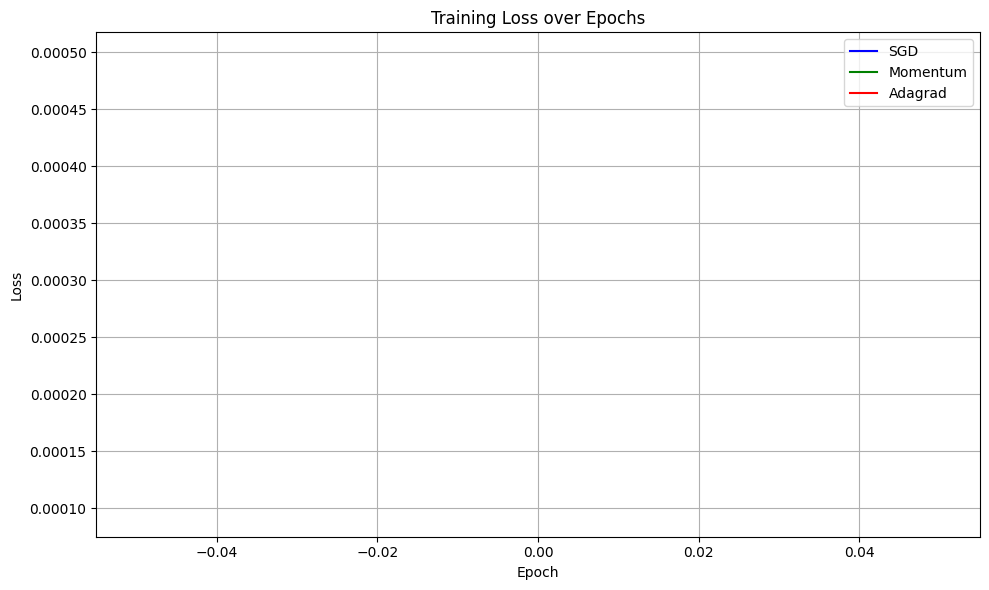

In [9]:
# Plot the loss graphs for alll optimizers
plt.figure(figsize=(10, 6))

plt.plot(losses1, color='blue', label='SGD')
plt.plot(losses2, color='green', label='Momentum')
plt.plot(losses3, color='red', label='Adagrad')

plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculation of AUC scores

scores1 = X_test @ W1
scores2 = X_test @ W2
scores3 = X_test @ W3
# Convert labels if needed, 1->1, -1->0 using true/false values
y_true_binary = (y_test == 1).astype(int)

auc1 = roc_auc_score(y_true_binary, scores1)
auc2 = roc_auc_score(y_true_binary, scores2)
auc3 = roc_auc_score(y_true_binary, scores3)
print("AUC:", auc1)
print("AUC:", auc2)
print("AUC:", auc3)

# PART 2

In [ ]:
class RFFRBFApproximator:
    def __init__(self,m=100,sigma=1.0):
        self.m = m
        self.sigma = sigma
        self.w = None
        self.b = None
    
    def fit(self,X, override=False):
        if (self.w is not None or self.b is not None) and not override:
            raise Exception("Kernel already fitted to data, to Introduce new data run function with override=True")
        self.w = np.random.normal(0, 1.0 / self.sigma, size=(self.m, X.shape[1]))
        self.b = np.random.uniform(0, 2 * np.pi, size=self.m)
    
    def transform(self, X):
        if self.w is None:
            raise Exception("Fit needs to be called before transform")
        if self.w.shape[1] != X.shape[1]:
            raise Exception("Data ill-formatted for w")
        
        z = np.sqrt(2.0 / self.m) * np.cos(X @ self.w.T + self.b)

        return z

In [ ]:
m_values = [100,200,300]
# Evaluation
svc = SVC(kernel='rbf')
for m in m_values:
    rff = RFFRBFApproximator(m=m,sigma=1.0) # setting sigma to 4.0/3.0 reduces loss drastically for toydataset_large
    rff.fit(X_train)
    X_train_rff = rff.transform(X_train)
    X_test_rff = rff.transform(X_test)
    
    for batch_size in [1, 32, 512]:
        print("\nBATCH SIZE = "+str(batch_size)+"\t m = "+str(m))
        # Train with sgd
        print("SGD")
        start = time.time()
        _, loss_sgd, _ = train_svm(X_train_rff, y_train, X_test_rff, y_test, "sgd", batch_size=batch_size)
        stop = time.time()
        print(f"Runtime: {stop - start:.4f} s")
        # Train with sgd with momentum
        print("SGD with MOMENTUM")
        start = time.time()
        _, loss_sgd_momentum, _ = train_svm(X_train_rff, y_train, X_test_rff, y_test, "momentum", batch_size=batch_size)
        stop = time.time()
        print(f"Runtime: {stop - start:.4f} s")
        # Train with adagrad
        print("ADAGRAD")
        start = time.time()
        _, loss_adagrad, _ = train_svm(X_train_rff, y_train, X_test_rff, y_test, "adagrad", batch_size=batch_size)
        stop = time.time()
        print(f"Runtime: {stop - start:.4f} s")

        svc.fit(X_train, y_train)
        print("fit")
        svc_pred = svc.predict(X_test)
        print("SVC test accuracy:",np.sum(svc_pred == y_test)/len(y_test))

        plt.figure()
        plt.plot(range(len(loss_sgd)),1-np.array(loss_sgd),label="SDG")
        plt.title(f"Train Accuracy for m =  {m}, batch size = {batch_size} with RFFs")        
        plt.plot(range(len(loss_sgd_momentum)),1-np.array(loss_sgd_momentum),label="SDG Momentum")
        plt.plot(range(len(loss_adagrad)),1-np.array(loss_adagrad), label="Adagrad")
        plt.legend()
        plt.savefig(f"rff_m_{m}_batch_{batch_size}.png",dpi=300)